In [4]:
import json
import csv
import numpy
import pytz
import pandas as pd
from binance.client import Client
import spacy
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import datetime

%matplotlib inline

# Get the coin price data from Binance.

In [5]:
coinfile = "coins_on_binance.csv"
with open(coinfile) as cf:
        rdr = csv.reader(cf)
        coins = []
        for row in rdr:
            coins.append(row)

Set up the Binance API to get the data we need.

In [6]:
client = Client("", "")

interval = Client.KLINE_INTERVAL_1MINUTE
start = "1 January, 2018"
end = "6 January, 2018"

The following function will get the historical price data for a given symbol (e.g. ETH) over the time interval.

In [7]:
def get_price_data(symbol):
    sym = symbol + "BTC"
    klines = client.get_historical_klines(sym, interval, start, end)

    j = []
    for t in klines:
        row = [t[6], t[4], t[2], t[3], t[5], t[8]]
        j.append(row)
    return j

Each output has the follow structure
[Close time, Close price, High, Low, Volume, Number of trades]

In [8]:
def get_all_price_data():
    prices = {}
    for c in coins:
        row = get_price_data(c[1])
        prices[c[1]] = row
    with open("all_prices.json", "w") as f:
        json.dump(prices, f)

In [9]:
with open("all_prices.json") as f:
    all_prices = json.load(f)

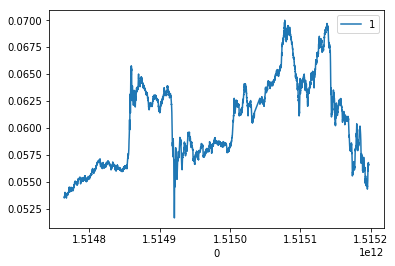

In [10]:
price_df = pd.DataFrame(all_prices['ETH'])
price_df.head()
price_df = price_df.astype(float)
price_df.plot.line(x=0, y=1)

# Reddit comment sentiment

In [8]:
filename = "RC_2018-01-06_crypto"
nlp = spacy.load('en')
occurances = {}

Get a list of coins on Binance:

Divide the comments based on references to coins:

In [13]:
occurances = []
with open("sentiment_comments.json", "r") as f:
    occurances = json.load(f)

# with open (filename) as f:
#     all_data = json.load(f)
# for rc in all_data:
#     spcomment = nlp(rc['body'])
#     for symbol_line in coins:
#         symbol = symbol_line[1]
#         name = symbol_line[0]
#         has_symbol = False
#         comment_dict = {'time': rc['created_utc'], 'body': rc['body'],
#                         'sentences' : [], 'subreddit': rc['subreddit']}
#         for sentence in spcomment.sents:
#             for word in sentence:
#                 if word.text.lower() == symbol.lower() or word.text.lower() == name.lower():
#                     has_symbol = True
#                     comment_dict['sentences'].append(sentence.text)
#                     break
#         if has_symbol:
#             if symbol in occurances:
#                 occurances[symbol].append(comment_dict)
#             else:
#                 occurances[symbol] = [comment_dict]

Sentiment:

In [14]:
goodwords = []
badwords = []

with open("good-words") as f:
    goodwords = [line.rstrip() for line in f]

with open("bad-words") as f:
    badwords = [line.rstrip() for line in f]


In [15]:
def check_sentiment(comment):
    good = 0
    bad = 0
    words = comment.lower().split()
   
    c = Counter(words)
    for g in goodwords:
        if g in words:
           
            good += c[g]
    for b in badwords:
        if b in words:
           
            bad += c[b]
    return good-bad, good, bad

In [16]:
for coin in occurances:
    for comment in occurances[coin]:
        comment['sentiment'], comment['good'], comment['bad'] = check_sentiment(comment['body'])



In [17]:
with open("sentiment_comments.json", "w") as f:
    json.dump(occurances, f)

Plotting things:

In [18]:
def plot_mentions(symbol_data, symbol):
    symoccurances_df = pd.DataFrame(symbol_data)
    symoccurances_df.head()
    symoccurances_df.plot(kind= 'hist', bins = 300, x = 'time')

In [19]:
def plot_length(symbol_data, symbol):
    for c in symbol_data:
        clen = 0
        for sentence in c['sentences']:
            clen += len(sentence)

        c['length'] = clen
       

    df = pd.DataFrame(symbol_data)
    
    df.head()
    df.plot(x = 'time', y ='length')

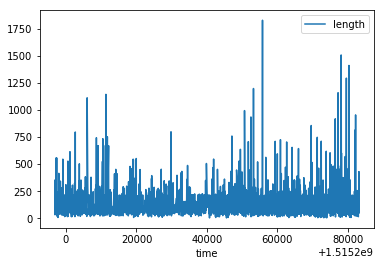

In [20]:
# occurances['XRP']
plot_length(occurances['XRP'], 'XRP')

In [21]:
def plot_sentiment(symbol_data, symbol, sentiment):
    symoccurances_df = pd.DataFrame(symbol_data)
#     Convert time to datetime type, it is in second format
    symoccurances_df['time'] = symoccurances_df['time'].astype('datetime64[s]')
    symoccurances_df.head()
    symoccurances_df.plot(x = 'time', y = sentiment)
    
  

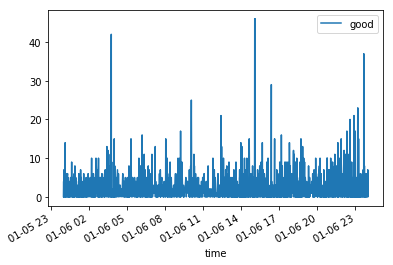

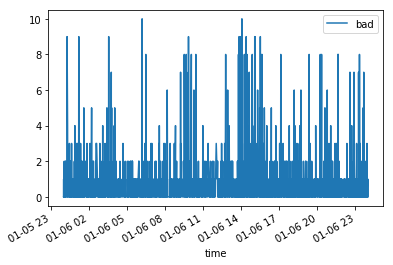

In [22]:
plot_sentiment(occurances['XRP'], 'XRP', 'good')
plot_sentiment(occurances['XRP'], 'XRP', 'bad')

Sentiment is still set to be good - bad.

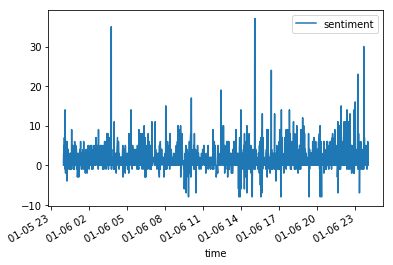

In [23]:
cur = 'XRP'
symbol_data = occurances[cur]
mydf = pd.DataFrame(symbol_data)
mydf['time'] = mydf['time'].astype('datetime64[s]')
mydf.head()

mydf.plot(x = 'time', y = 'sentiment')

## Plot both good and bad on the same axes

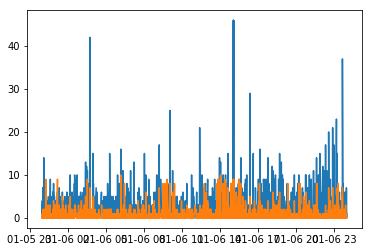

In [50]:
cur = 'XRP'
# Sort out the sentiment data
symbol_data = occurances[cur]
mydf = pd.DataFrame(symbol_data)
mydf['time'] = mydf['time'].astype('datetime64[s]')

# Plot both of them
plt.plot(mydf.time, mydf.good)
plt.plot(mydf.time, mydf.bad)
plt.show()

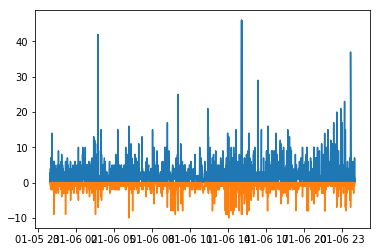

In [52]:
cur = 'XRP'
# Sort out the sentiment data
symbol_data = occurances[cur]
mydf = pd.DataFrame(symbol_data)
mydf['time'] = mydf['time'].astype('datetime64[s]')
mydf['bad'] = mydf['bad'] * -1

# Plot both of them
plt.plot(mydf.time, mydf.good)
plt.plot(mydf.time, mydf.bad)
plt.show()

## Plotting sentiment and cost


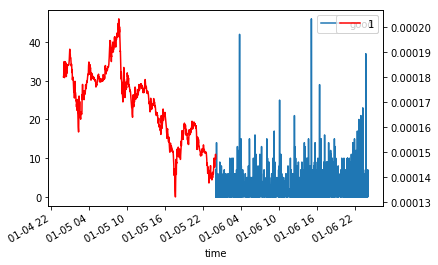

In [49]:
cur = 'XRP'
# Sort out the sentiment data
symbol_data = occurances[cur]
mydf = pd.DataFrame(symbol_data)
mydf['time'] = mydf['time'].astype('datetime64[s]')

# Sort out cost data
price_df = pd.DataFrame(all_prices['XRP'])
price_df = price_df.astype(float)
# Convert the float into a datetime. It is in ms format.
price_df[0] = price_df[0].astype('datetime64[ms]')
# Filter it to only do this day
price_df[0] = price_df[(price_df[0] > '2018-01-04 23:59:00') & (price_df[0] < '2018-01-08 00:00:01')]

# Note, these times don't line up.

mydf['good']

fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx()

mydf.plot(x='time', y='good', kind='line', ax=ax)
price_df.plot(x=0, y=1, kind='line', ax=ax2, color='red')
